# Trabalho 01

Este *notebook* tem como objetivo aplicar todos os conceitos aprendidos no processamento do sinal
para o *dataset -* 8 SSVEP-BCI no modo *offline*.

**Nota:** O arquivo `requirements.txt` contém todas as dependências necessárias.
Para instalar (no linux), basta fazer:

```
$ pip install -r requirements.txt
```

## Dependências

In [1]:
# bloco apenas com organizações de imports
from google_drive_downloader import GoogleDriveDownloader as gdd
import numpy as np
import json
import matplotlib
import mne
import scipy
from scipy.signal import stft
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics

%matplotlib inline

## Preparação do *dataset* de trabalho

In [2]:
# bloco de declaração dos identificadores de download (google drive) e setup
dataset_ids = {
    1: '1ym3JqI4_ZYNSBLxoF1vNxI5Hsgur_tha',
    2: '1tJ5tHbE-2jwr0gA33Gd873lRPao-e4dF',
    3: '1tXdpY-mser01POaP6Qwixny6LjsXXoXB',
    4: '1T00cliWp5yqqbbWZ7-rf2X4tOUQ-PvIQ',
    5: '1CYsBFMul9zB_vCy0XD7XVfKUl8vihDYZ',
    6: '1io6jdALBKeopELWXahPzuAi6EfYDgviW',
    7: '1YDkheRDPNDR1ujsqqC_SY6cebWHkw9Xt',
    8: '1jjoQJFDCi7O9Q-iaReAPpQnxC-HIKpQi',
}
label_id = '1mD5MXoh6tfQJFXIvdw2MQsEu6vZka6C0'
desc = '14kYNBZYdttqmSS_Vz6Bm_ztG9Uw1MC0y'

# ALTERE O ID DO DATASET DE SUA ESCOLHA AQUI - NO CASO DESSE TRABALHO: 8
DS = 8

In [3]:
# download do stataset
gdd.download_file_from_google_drive(file_id=dataset_ids[DS],
                                    dest_path='files/data.npy',
                                    showsize=True)
# download do arquivo de marcações
gdd.download_file_from_google_drive(file_id=label_id,
                                    dest_path='files/labels.npy', showsize=True)

# download do arquivo de descrição
gdd.download_file_from_google_drive(file_id=desc,
                                    dest_path='files/descriptor.json',
                                    showsize=True)

### Carregamento do *dataset* de trabalho

In [4]:
X = np.load('files/data.npy')
y = np.load('files/labels.npy')
desc_file = open('files/descriptor.json')
descriptor = json.loads(desc_file.read())
desc_file.close()
print('Estruturas => dados', X.shape, 'labels', y.shape)

Estruturas => dados (125, 257, 1205) labels (125,)


Os dados estão estruturados em *numpy arrays*.

O "shape" `(125, 257, 1205)` para os dados EEG de `X`, significa que existem 125 *trials* (tradução aceitável: ensaio, julgamento), 257 *channels* que representam os eletrodos e 1205 dados que representam o potencial mensurado em ponto flutuante. Este é um array com **três dimensões**.

O "shape" `(125,)` para os dados de *labels* ou marcadores `y`, apresentam qual é o eletrodo respectivo a cada *trial*. Os *labels* estão com valores numéricos, o que facilita o processamento, mas não é intuitivo. 

Desta forma, foi preparado um arquivo de descrição no qual é possível saber qual é o rótulo do *dataset*, além de outras informações como a taxa de amostragem (sampling rate), idade, tipo do cabelo (curto, médio ou comprido), sexo, tamanho da touca e se é destro ou canhoto. Veja os dados do voluntário escolhido:

In [5]:
print('Características do voluntário:', descriptor[str(DS)])
print('\nRótulos:', descriptor['frequencies'])
print('\nTaxa de amostragem:', descriptor['sampling_rate'])

Características do voluntário: {'age': '25', 'capsize': 'Adult Medium', 'gender': 'Male', 'hairtype': 'Regular', 'handedness': 'Right'}

Rótulos: {'1': 6.66, '2': 7.5, '3': 8.57, '4': 10.0, '5': 12.0}

Taxa de amostragem: 250


Apesar do autor do *dataset* apresentar os `Rótulos {'1': 6.66, '2': 7.5, '3': 8.57, '4': 10.0, '5': 12.0}` verificou-se que os mesmos ocorrem em ordem inversa.

`Rótulos Corretos: {'5': 6.66, '4': 7.5, '3': 8.57, '2': 10.0, '1': 12.0}`

E ainda apresentou a taxa de amostragem da captura dos dados igual a `250 Hz`, o mesmo não foi verificado por meio dos dados. Os dados dos voluntários estão desbalanceados em quantidade, o que não nos permite criar um `numpy.array`, apenas vetores não esparsos. Desta forma, teremos que recalcular a taxa de amostragem (*sample rate*):

In [6]:
# quantidade_de_dados / tempo_do_trial
descriptor['sampling_rate'] = X.shape[-1] / 5
print('Nova taxa de amostragem: {} Hz'.format(descriptor['sampling_rate']))

Nova taxa de amostragem: 241.0 Hz


## Utilizando MNE para representar e trabalhar com os dados

A biblioteca MNE é usada para representar os dados de EEG, facilitando o armazenamento de todas as informações em um único objeto.

Além disso, somente a biblioteca MNE permite executar diversas operações de pré-processamento do *dataset*, além de outras operações utilizadas durante o processamento SSVEP.

### MNE *info descriptor*

O primeiro passo é criar um objeto `info`, que servirá como descrição do objeto MNE. Os valores mais importantes de descrição do objeto são: nome dos eletrodos: `montage.ch_names`, taxa de amostragem: `descriptor['sampling_rate']` e tipo do sinal: `'eeg'`.

In [7]:
# aumentando a escala das figuras no matplotlib (padrão 6. x 4.)
matplotlib.rcParams['figure.figsize'] = [12, 8]

# objeto com o nome dos canais pelo modelo da touca utilizada
montage = mne.channels.make_standard_montage('EGI_256')

# criando o objeto `info` (o restante dos valores já temos)
info = mne.create_info(montage.ch_names,
                       sfreq=descriptor['sampling_rate'],
                       ch_types='eeg')

info.set_montage(montage)
info

<Info | 8 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 256 EEG
 custom_ref_applied: False
 dig: 259 items (3 Cardinal, 256 EEG)
 highpass: 0.0 Hz
 lowpass: 120.5 Hz
 meas_date: unspecified
 nchan: 256
 projs: []
 sfreq: 241.0 Hz
>

Podemos verificar que o nome dos canais não nos ajudou muito. Isto ocorre porque o modelo utilizado não é o "padrão 10-20" ou "padrão 10-05". Desta forma, nome de canais como `O1`, `O2`, `Pz` não estarão explícitos para consulta e outras operações.

Vamos então utilizar informações do artigo, no qual são mostradas alguns mapeamentos destes nomes genéricos (`E1`, `E2`, etc) para os nomes no padrão internacional 10-20:

| 256 HCGSN | 10-20 System | 256 HCGSN | 10-20 System | 256 HCGSN | 10-20 System | 256 HCGSN | 10-20 System |
|:---------:|:------------:|:---------:|:------------:|:---------:|:------------:|:---------:|:------------:|
|     47    |      F7      |     21    |      Fz      |    202    |      T8      |     31    |      NAS     |
|     37    |      Fp1     |    183    |      C4      |    116    |      O1      |     69    |      T7      |
|     36    |      F3      |    170    |      P8      |     94    |      LM      |    190    |      RM      |
|     2     |      F8      |    150    |      O2      |     18    |      Fp2     |    126    |      Oz      |
|    101    |      Pz      |    224    |      F4      |     96    |      P7      |

Além desse mapeamento aproximado, podemos comparar outros, por meio de mapeamentos dos padrões armazenados na própria biblioteca:

EGI 256
Creating RawArray with float64 data, n_channels=256, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


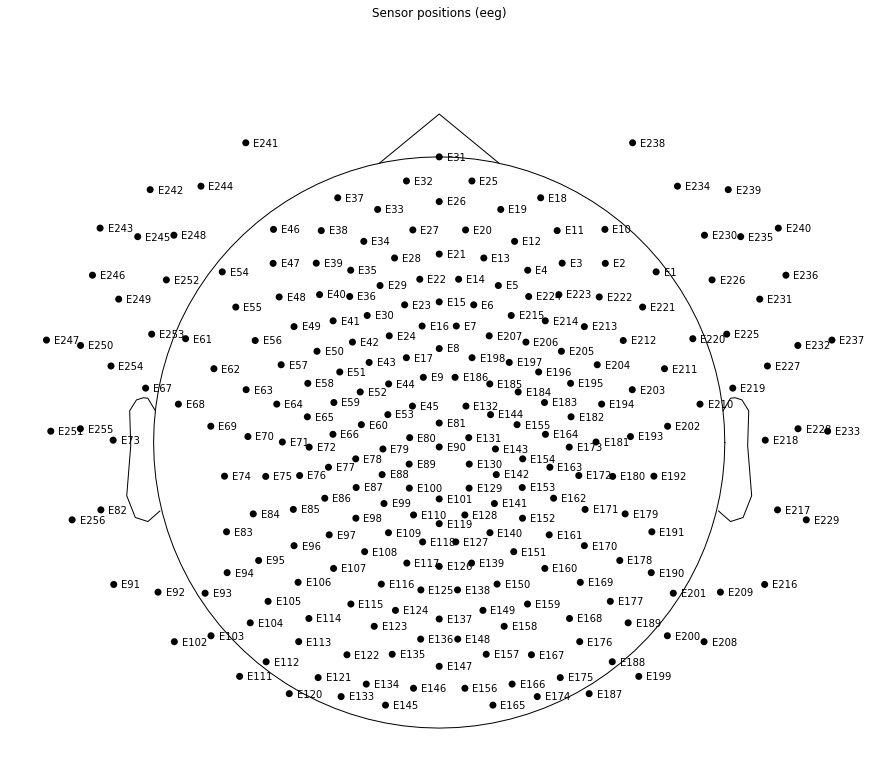

10-20 SYSTEM
4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


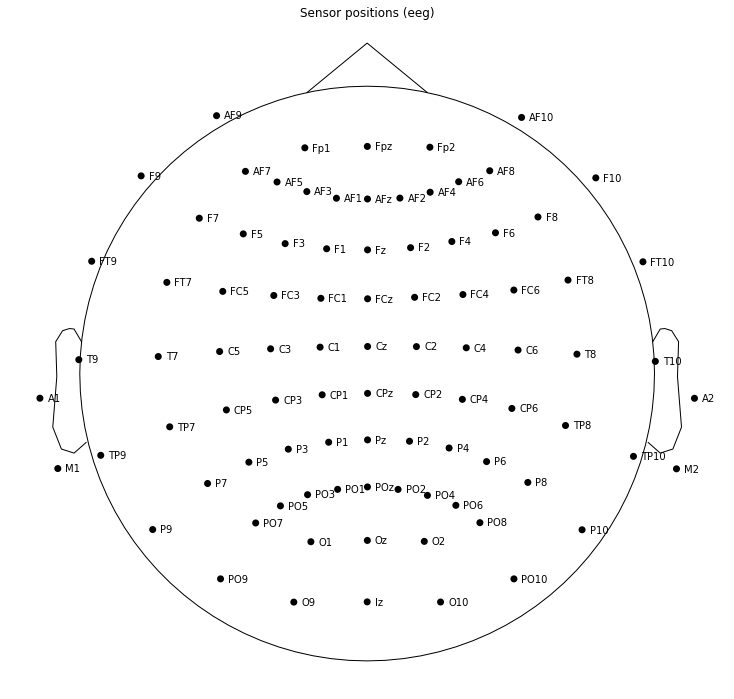

In [8]:
# plotando o padrão EGI 256
print('EGI 256')
montage.plot()

# plotando o padrão 10-20
print('10-20 SYSTEM')

matplotlib.rcParams['figure.figsize'] = [10, 7]
mne.channels.make_standard_montage('standard_1020').plot()
print()

### Criando objeto MNE Epoch

A princípio, precisamos preparar o parâmetro `events` do objeto `EpochArray`, que armazena os marcadores do experimento (aqueles marcadores que estão armazenados no nosso objeto `descriptor`).

Por fim, adicionamos o parâmetro `info` que acabamos de criar.

In [9]:
# o 257º eletrodo é o VREF (referência). Podemos tirá-lo.
X = X[:,:256,:]

# objeto event é uma matriz tridimensional conforme explicado em aula
events = np.array([[i, 0, e] for i, e in enumerate(y)])

# instanciando objeto EpochArray
epoch = mne.EpochsArray(X, info, events=events)
epoch

125 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


<EpochsArray  |   125 events (all good), 0 - 4.99585 sec, baseline off, ~294.8 MB, data loaded,
 '1': 25
 '2': 25
 '3': 30
 '4': 25
 '5': 20>

### Iniciando trabalhos com MNE Epoch

Com o objeto MNE criado, podemos realizar as operações.

A primeira coisa que faremos é filtrar alguns eletrodos de maior interesse (p/ experimentos SSVEP), foram selecionados 50 eletrodos:

In [10]:
epoch_welch = epoch.copy().pick_channels(['E95','E96','E97','E98','E99','E100',
                                        'E101','E105','E106','E107','E108','E109','E110',
                                        'E113','E114','E115','E116','E117','E118','E119',
                                        'E122','E123','E124','E125','E126','E127','E128','E129',
                                        'E135','E136','E137','E138','E139','E140',
                                        'E141','E147','E148','E149','E150',
                                        'E151','E152','E157','E158','E159','E160',
                                        'E161','E168','E169','E170',
                                        'E178'])
epoch_welch

<EpochsArray  |   125 events (all good), 0 - 4.99585 sec, baseline off, ~57.7 MB, data loaded,
 '1': 25
 '2': 25
 '3': 30
 '4': 25
 '5': 20>

Para demonstrar que estamos apenas com os eletrodos escolhidos, mostramos o shape de ambos os objetos criados.

In [11]:
print(epoch.get_data().shape)
print(epoch_welch.get_data().shape)

(125, 256, 1205)
(125, 50, 1205)


## Etapa de Pré-Processamento

### Filtros espaciais

Filtros espaciais são utilizados para escolher canais de dados que melhor respondem a uma determinada tarefa. No caso do paradigma SSVEP, espera-se encontrar o conjunto de eletrodos que possuem respostas mais significativas em relação à frequências evocadas. Um algoritmo muito utilizado para este fim é o *CAR* (`Common Average Reference`).

Nesse caso foi utilizado a média. No MNE a implementação do *CAR* se dá pela aplicação do método `set_eeg.reference`:

In [12]:
epo_ref = mne.set_eeg_reference(epoch_welch, ref_channels=['E95','E96','E97','E98','E99','E100',
                                                        'E101','E105','E106','E107','E108','E109','E110',
                                                        'E113','E114','E115','E116','E117','E118','E119',
                                                        'E122','E123','E124','E125','E126','E127','E128','E129',
                                                        'E135','E136','E137','E138','E139','E140',
                                                        'E141','E147','E148','E149','E150',
                                                        'E151','E152','E157','E158','E159','E160',
                                                        'E161','E168','E169','E170',
                                                        'E178'])
epo_ref

EEG channel type selected for re-referencing
Applying a custom EEG reference.


(<EpochsArray  |   125 events (all good), 0 - 4.99585 sec, baseline off, ~57.7 MB, data loaded,
  '1': 25
  '2': 25
  '3': 30
  '4': 25
  '5': 20>,
 array([[-663.018293  , -670.70299667, -679.51876144, ..., -463.3864093 ,
         -463.18609985, -460.27948669],
        [-158.77751236, -161.33793533, -158.66452688, ...,  -28.18680199,
          -31.50181503,  -29.13924347],
        [ 147.07370544,  152.69054016,  153.20662476, ...,  237.92565308,
          233.6788002 ,  233.53854294],
        ...,
        [-639.21148224, -643.17235771, -638.81780701, ..., -642.37642166,
         -637.91658234, -634.00031494],
        [-629.69196419, -635.30676346, -630.99720894, ..., -665.64509842,
         -660.28201004, -658.69720016],
        [-649.95153519, -646.26245682, -646.52328552, ..., -645.04517838,
         -652.69100525, -650.15173187]]))

### Filtros temporais

O filtro é dito temporal pois influencia diretamente na periodicidade das diversas frequências presentes em um sinal de EEG por exemplo.

Foi utilizado filtro `band pass`, mas para gerar ele foi aplicado o filtro `low pass` e o filtro `high pass` em sequência. E foi constatado ainda que quando se aplica esse processo 4 vezes o resultado melhorou, mas quando se aplicou 3 ou 5, o resulta teve uma pequena queda.

In [13]:
# Limitando as frequências
fmin = 6.0
fmax = 13.0

epo_bp = epo_ref[0].filter(l_freq=fmin, h_freq=None)
epo_bp = epo_bp.filter(l_freq=None, h_freq=fmax)

epo_bp = epo_bp.filter(l_freq=fmin, h_freq=None)
epo_bp = epo_bp.filter(l_freq=None, h_freq=fmax)

epo_bp = epo_bp.filter(l_freq=fmin, h_freq=None)
epo_bp = epo_bp.filter(l_freq=None, h_freq=fmax)

epo_bp = epo_bp.filter(l_freq=fmin, h_freq=None)
epo_bp = epo_bp.filter(l_freq=None, h_freq=fmax)

Setting up high-pass filter at 6 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 399 samples (1.656 sec)

Setting up low-pass filter at 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 245 samples (1.017 sec)

Setting up high-pass filter at 6 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) 

### Transformação de domínio

Foi utilizado o `método Welch` para realizar a estimação PSD.

In [14]:
epoch_welch, freqs = mne.time_frequency.psd_welch(epo_bp, n_per_seg=32, n_overlap=16)
# epoch_welch1, freqs = mne.time_frequency.psd_welch(epo_bp, fmax=9.8, n_per_seg=32, n_overlap=16)
# epoch_welch2, freqs = mne.time_frequency.psd_welch(epo_bp, fmin=11.2, n_per_seg=32, n_overlap=16)
print(epoch_welch.shape)

Effective window size : 1.062 (s)
(125, 50, 129)


## Criação do vetor de características

### Aplicando Welch novamente

Sim, o `método Welch` foi aplicado 2 vezes. Isso fez com que o resultado melhorasse e muito.

In [15]:
freqs, epoch_welch = scipy.signal.welch(epoch_welch, fs=241, nperseg=32, noverlap=16)

In [16]:
W = np.abs(epoch_welch) ** 2

print(W.shape)

(125, 50, 17)


### Extração de características

Não é uma boa estratégia utilizar os dados *crus* de PSD para a classificação. Foi adotado alguns algoritmos simples para reduzir uma dimensão dos dados e potencializar nossas características. As características utilizadas foram retiradas deste artigo: [A wearable wireless brain-computer interface using steady-state visual evoked potentials](https://www.researchgate.net/publication/334854837_A_wearable_wireless_brain-computer_interface_using_steady-state_visual_evoked_potentials). Das características citadas no artigo, foram testadas 15, das quais foram utilizadas 13:

In [17]:
# Mean - 1 --
fmn = np.mean(W, axis=-1)
print('FMN:', fmn.shape)

# Max - 2 --
mx = np.amax(W, axis=-1)
print('MAX:', mx.shape)

# Min - 3 --
mn = np.amin(W, axis=-1)
print('MIN:', mn.shape)

# Standard deviation (SD) - 4 --
sd = scipy.stats.tstd(W, axis=-1)
print('SD:', sd.shape)

# Root mean square - 5*
rms = np.sqrt(np.mean(W, axis=-1))
print('RMS:', rms.shape)

# Root of sum of squares - 6*
rss = np.sqrt(np.sum(W, axis=-1))
print('RSS:', rss.shape)

# Kurtosis 7 *
kur = scipy.stats.kurtosis(W, axis=-1)
print('KUR:', kur.shape)

# Skewness 8
skw = scipy.stats.skew(W, axis=-1)
print('SKW:', skw.shape)

# Absolute value mean - 9 --
mav = np.mean(np.absolute(W), axis=-1)
print('MAV:', mav.shape)

# Quartiles 1 - 10*
qrt1 = np.quantile(W, .25, axis=-1)
print('QRT1:', qrt1.shape)

# Quartiles 2 - 11*
qrt2 = np.quantile(W, .50, axis=-1)
print('QRT2:', qrt2.shape)

# Quartiles 3 - 12
qrt3 = np.quantile(W, .75, axis=-1)
print('QRT3:', qrt3.shape)

# AUC - 13
auc = np.absolute(np.trapz(W, axis=-1))
print('AUC:', auc.shape)

# VAR - 14
var = scipy.stats.variation(W, axis=-1)
print('VAR:', var.shape)

# moment - 15
mom = scipy.stats.moment(W, axis=-1)
print('MOM:', mom.shape)

FMN: (125, 50)
MAX: (125, 50)
MIN: (125, 50)
SD: (125, 50)
RMS: (125, 50)
RSS: (125, 50)
KUR: (125, 50)
SKW: (125, 50)
MAV: (125, 50)
QRT1: (125, 50)
QRT2: (125, 50)
QRT3: (125, 50)
AUC: (125, 50)
VAR: (125, 50)
MOM: (125, 50)


In [18]:
# Junção das  características criadas
features = list()
for feature in (fmn, sd, rms, rss, kur, mav, qrt1, qrt2, qrt3, skw, auc, var, mom,):
    features.append(feature)

# vetor de características final
X = np.concatenate(features, axis=-1)
print('Shape dos dados:', X.shape)

Shape dos dados: (125, 650)


#### Adaptação do vetor de labels

Temos que adaptar o vetor de *labels* para ficar do mesmo tamanho (mesma quantidade de linhas) que o vetor de dados X.

In [19]:
y = np.load('files/labels.npy')
print('Shape original dos labels', y.shape)

size = int(X.shape[0] / y.shape[0])
y = np.concatenate([y for i in range(size)])
print('Shape final dos labels', y.shape)

Shape original dos labels (125,)
Shape final dos labels (125,)


In [20]:
# import sklearn
# print(X.shape)
# scaler = sklearn.preprocessing.StandardScaler(with_mean=False, with_std=False)
# X = scaler.fit_transform(X)

## Classificação

A última etapa de uma aplicação de processamento de sinais é a classificação dos dados. Vamos utilizar o vetor de características e o vetor com os rótulos.

### Métodos de classificação

Para realizar a classificação foram utilizados os classificadores da biblioteca *scikit-learn*. O classificador que obteve o melhor resultado foi o: `SVM (Support Vector Machine)`.

#### SVM - Support Vector Machine

In [22]:
kernel = 'linear'
for count in range(15000):
    for C in [0.1, 1, 10, 100, 1000, 10000]:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=0.7, shuffle=True, stratify=y)
        clf = SVC(kernel=kernel, C=C)
        clf = clf.fit(X_train, y_train)
        res = clf.predict(X_test)
        tot_hit = sum([1 for i in range(len(res)) if res[i] == y_test[i]])
        if ( 100*metrics.accuracy_score(y_test, res) >= 94.0): # 92.11 e 97.37
            print(count)
            print('Acurácia: {:.2f}%'.format(tot_hit / X_test.shape[0] * 100))
            print('Kernel:{} | C:{} | Accuracy: {:.2f}%'.format(
                kernel, C, 100*metrics.accuracy_score(y_test, res))
            )

26
Acurácia: 94.74%
Kernel:linear | C:1000 | Accuracy: 94.74%
203
Acurácia: 94.74%
Kernel:linear | C:100 | Accuracy: 94.74%
239
Acurácia: 94.74%
Kernel:linear | C:100 | Accuracy: 94.74%
291
Acurácia: 94.74%
Kernel:linear | C:100 | Accuracy: 94.74%
505
Acurácia: 94.74%
Kernel:linear | C:100 | Accuracy: 94.74%
845
Acurácia: 94.74%
Kernel:linear | C:1000 | Accuracy: 94.74%
949
Acurácia: 94.74%
Kernel:linear | C:100 | Accuracy: 94.74%
1195
Acurácia: 94.74%
Kernel:linear | C:100 | Accuracy: 94.74%
1364
Acurácia: 97.37%
Kernel:linear | C:1000 | Accuracy: 97.37%
1364
Acurácia: 94.74%
Kernel:linear | C:10000 | Accuracy: 94.74%
1648
Acurácia: 94.74%
Kernel:linear | C:10 | Accuracy: 94.74%
1834
Acurácia: 97.37%
Kernel:linear | C:1000 | Accuracy: 97.37%
1940
Acurácia: 94.74%
Kernel:linear | C:10000 | Accuracy: 94.74%
2269
Acurácia: 94.74%
Kernel:linear | C:1000 | Accuracy: 94.74%
2769
Acurácia: 94.74%
Kernel:linear | C:100 | Accuracy: 94.74%
2822
Acurácia: 94.74%
Kernel:linear | C:100 | Accuracy:

In [ ]:
for count in range(3000):
    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
        for gamma in [10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]:
            for C in [0.01, 0.1, 1, 10, 100, 1000, 10000]:
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, train_size=0.7, shuffle=True, stratify=y)
                clf = SVC(kernel=kernel,gamma=0.0001, C=C)
                clf = clf.fit(X_train, y_train)
                res = clf.predict(X_test)
                tot_hit = sum([1 for i in range(len(res)) if res[i] == y_test[i]])
                if ( 100*metrics.accuracy_score(y_test, res) >= 94.0): # 92.11 e 94.74 (1 vez)
                    print(count)
                    print('Acurácia: {:.2f}%'.format(tot_hit / X_test.shape[0] * 100))
                    print('Kernel:{} | Gamma:{} e C:{} | Accuracy: {:.2f}%'.format(
                        kernel, gamma, C, 100*metrics.accuracy_score(y_test, res))
                    )

18
Acurácia: 94.74%
Kernel:linear | Gamma:0.1 e C:10000 | Accuracy: 94.74%
33
Acurácia: 94.74%
Kernel:linear | Gamma:1e-06 e C:100 | Accuracy: 94.74%
63
Acurácia: 94.74%
Kernel:linear | Gamma:0.0001 e C:100 | Accuracy: 94.74%
81
Acurácia: 94.74%
Kernel:linear | Gamma:0.1 e C:100 | Accuracy: 94.74%
106
Acurácia: 94.74%
Kernel:linear | Gamma:0.001 e C:100 | Accuracy: 94.74%
122
Acurácia: 94.74%
Kernel:linear | Gamma:1 e C:100 | Accuracy: 94.74%
148
Acurácia: 94.74%
Kernel:linear | Gamma:0.1 e C:10000 | Accuracy: 94.74%
152
Acurácia: 94.74%
Kernel:linear | Gamma:1 e C:1000 | Accuracy: 94.74%
171
Acurácia: 94.74%
Kernel:linear | Gamma:0.1 e C:1000 | Accuracy: 94.74%
230
Acurácia: 94.74%
Kernel:linear | Gamma:1e-06 e C:100 | Accuracy: 94.74%
266
Acurácia: 94.74%
Kernel:linear | Gamma:0.001 e C:10000 | Accuracy: 94.74%
288
Acurácia: 94.74%
Kernel:linear | Gamma:1e-05 e C:100 | Accuracy: 94.74%
300
Acurácia: 94.74%
Kernel:linear | Gamma:1e-05 e C:10000 | Accuracy: 94.74%
315
Acurácia: 94.74%
